<a href="https://colab.research.google.com/github/mit1280/Document-AI/blob/main/UDOP_DocLayNet_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece bitsandbytes datasets seqeval

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,226 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
from transformers import UdopForConditionalGeneration
import torch
from datasets import load_dataset
from datasets.features import ClassLabel
from PIL import ImageDraw, ImageFont, Image
import pytesseract
import random
from huggingface_hub import notebook_login

In [ ]:
image = Image.open("test.png")
image = image.convert("RGB")
# image


In [ ]:
ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)

In [ ]:
# https://huggingface.co/datasets/nielsr/funsd-layoutlmv3/blob/main/funsd-layoutlmv3.py
def get_line_bbox( bboxs):
        x = [bboxs[i][j] for i in range(len(bboxs)) for j in range(0, len(bboxs[i]), 2)]
        y = [bboxs[i][j] for i in range(len(bboxs)) for j in range(1, len(bboxs[i]), 2)]

        x0, y0, x1, y1 = min(x), min(y), max(x), max(y)

        assert x1 >= x0 and y1 >= y0
        bbox = [x0, y0, x1, y1]
        return bbox

In [ ]:
texts_list = []
bboxs_list =[]

for i, j in ocr_df.groupby('block_num'):
  text = ' '.join(j['text'])
  if text != ' ' and text.strip()!='':
    texts_list.append(text)
    box = []
    for left, top, width, height in zip(j['left'].tolist(), j['top'].tolist(), j['width'].tolist(), j['height'].tolist()):
      box.append([left, top, left+width, top+height])

    bboxs_list.append(get_line_bbox(box))

In [ ]:
image_path = "test.png"

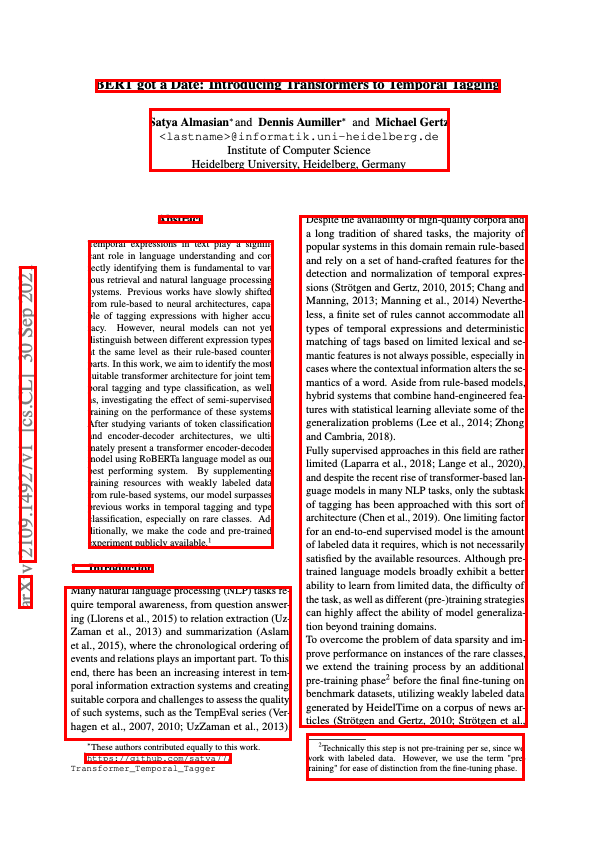

In [ ]:
# Load the image
# image screenshot https://www.researchgate.net/publication/354983472_BERT_got_a_Date_Introducing_Transformers_to_Temporal_Tagging
image = Image.open(image_path)
draw = ImageDraw.Draw(image)
# Define the bounding box
for bounding_box in bboxs_list:
    draw.rectangle(bounding_box, outline="red", width=3)
image

In [ ]:
# Normalize box diamentions to range 0 to 1000
def normalized_box(box, image_width=1025, image_height=1025):
    return [
        int(1000 * (box[0] / image_width)),
        int(1000 * (box[1] / image_height)),
        int(1000 * (box[2] / image_width)),
        int(1000 * (box[3] / image_height)),
    ]
def convert_box(bbox):
    x, y, w, h = tuple(bbox) # Box coordinates are in (left, top, width, height) format
    return [x, y, x+w, y+h] # we need to convert it into (x1, y1, x2, y2) which is (left, top, left+widght, top+height)

In [ ]:
from transformers import UdopForConditionalGeneration, AutoProcessor, AutoModelForTokenClassification

model_name = 'Mit1208/UDOP-finetuned-DocLayNet-1'
processor = AutoProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers import UdopEncoderModel, UdopPreTrainedModel, UdopConfig
from transformers.modeling_outputs import TokenClassifierOutput
from torch import nn

class UdopForTokenClassification(UdopPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.udop = UdopEncoderModel.from_pretrained(model_name)
    self.num_labels = config.num_labels

    self.dropout = nn.Dropout(0.5)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, input_ids, bbox, attention_mask, pixel_values, labels=None):
    outputs = self.udop(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, pixel_values=pixel_values)
    sequence_output = outputs[0]

    seq_length = input_ids.shape[1]
    # only take the text part of the output representations
    sequence_output = outputs[0][:, :seq_length]
    sequence_output = self.dropout(sequence_output)

    logits = self.classifier(sequence_output)

    loss = None
    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

In [ ]:
model = UdopForTokenClassification.from_pretrained("Mit1208/UDOP-finetuned-DocLayNet-1")

Some weights of UdopEncoderModel were not initialized from the model checkpoint at Mit1208/UDOP-finetuned-DocLayNet-1 and are newly initialized: ['encoder.block.0.layer.0.SelfAttention.k.weight', 'encoder.block.0.layer.0.SelfAttention.o.weight', 'encoder.block.0.layer.0.SelfAttention.q.weight', 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'encoder.block.0.layer.0.SelfAttention.v.weight', 'encoder.block.0.layer.0.layer_norm.weight', 'encoder.block.0.layer.1.DenseReluDense.wi.weight', 'encoder.block.0.layer.1.DenseReluDense.wo.weight', 'encoder.block.0.layer.1.layer_norm.weight', 'encoder.block.1.layer.0.SelfAttention.k.weight', 'encoder.block.1.layer.0.SelfAttention.o.weight', 'encoder.block.1.layer.0.SelfAttention.q.weight', 'encoder.block.1.layer.0.SelfAttention.v.weight', 'encoder.block.1.layer.0.layer_norm.weight', 'encoder.block.1.layer.1.DenseReluDense.wi.weight', 'encoder.block.1.layer.1.DenseReluDense.wo.weight', 'encoder.block.1.layer.1.layer_norm.wei

In [ ]:
img = Image.open(image_path).convert('RGB').resize((1000, 1000))
image_width, image_height = img.size
normalized_bboxes_list = [normalized_box((bboxs), image_width, image_height) for bboxs in bboxs_list]

In [ ]:
encoding = processor(img, texts_list, boxes=normalized_bboxes_list, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
outputs = model(**encoding)

In [ ]:
label_list = list(model.config.label2id.keys())
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(label_list))
font = ImageFont.load_default()
label2color = {label: colors[idx] for idx, label in enumerate(label_list)}

In [ ]:
logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

In [ ]:
# Initialize variables to store the filtered lists and the previous bounding box
filtered_predictions = []
filtered_token_boxes = []
previous_box = None

# Iterate through predictions and token_boxes simultaneously
for prediction, token_box in zip(predictions, token_boxes):
    # If the current bounding box is different from the previous one,
    # add the corresponding prediction to the filtered list
    if token_box != previous_box:
        filtered_predictions.append(prediction)
        filtered_token_boxes.append(token_box)
        previous_box = token_box  # Update previous_box to the current bounding box

# Print the filtered lists
print(filtered_predictions)
print(filtered_token_boxes)


[5, 5, 5, 9, 7, 9, 7, 9, 0]
[[19, 266, 36, 562], [18, 575, 32, 608], [95, 79, 500, 92], [149, 108, 449, 171], [158, 215, 202, 223], [88, 240, 273, 548], [72, 564, 153, 572], [64, 586, 291, 740], [1000, 1000, 1000, 1000]]


In [ ]:
def unnormalize_box(bbox, width, height):
    # print(bbox)
    return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


width, height = img.size
print(width, height)


1000 1000


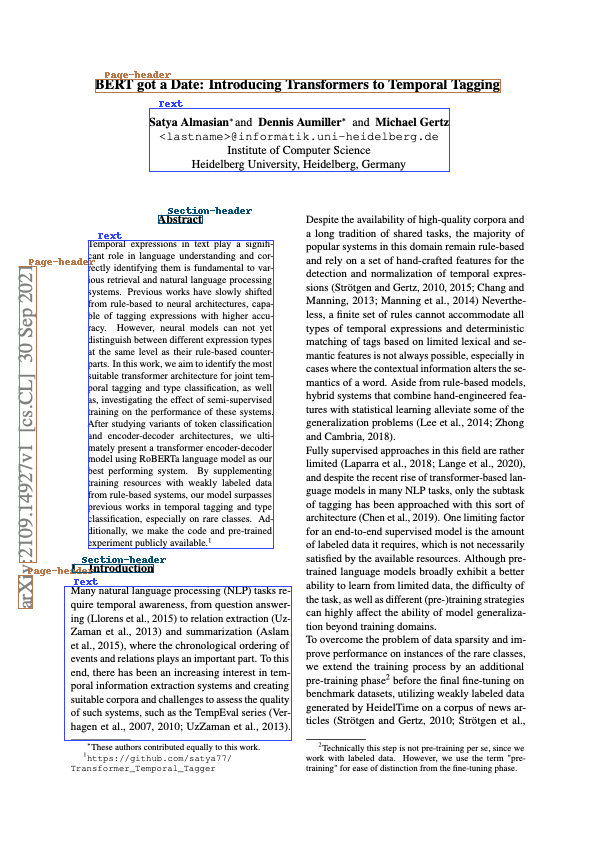

In [ ]:
from PIL import ImageDraw, ImageFont

test_image = Image.open(image_path)
test_draw = ImageDraw.Draw(test_image)
font = ImageFont.load_default()

def iob_to_label(label):
    # label = label[2:]
    if not label:
      return 'other'
    return label


for predicted_label, box in zip(filtered_predictions, filtered_token_boxes):
    predicted_label = model.config.id2label[predicted_label]
    test_draw.rectangle(box, outline=label2color[predicted_label])
    test_draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

test_image

## Reference
1. https://github.com/NielsRogge/Transformers-Tutorials/blob/master/UDOP/Fine_tune_UDOPEncoderModel_on_FUNSD_(HuggingFace_Trainer).ipynb
2. https://github.com/mit1280/Document-AI/blob/main/LayoutLMv3_Inference.ipynb